In [1]:
import pandas as pd
import numpy as np
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import keyboard
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

2023-03-28 10:25:02.597307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Data loading and preparation
data = pd.read_json('../datasets/dataset.json')
mapping = {False: 0, True: 1}
data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['violation'], axis=1, inplace=True)
data.shape

(86439, 2)

In [4]:
data.head()

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0


# Preprocessing function

In [5]:
def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', "'", '(', ')', ':', '-', '--', '', '?', '@', '....', '~',
                     '.', '..', '...', '<', '>', '=', '\'\'', '//', '»', '|', '’', '`', '+'
                     '\"\"', '</', '&', '/', '#', '\'', '*', '``', '%', '[', ']', '{', '}']

stop_words = stopwords.words('english') + ['14000kbps', "n't", "'s", "'m", 'mp4', 'error', '404']
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [6]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [7]:
data[:1000].apply(lambda row: str(row.text), axis=1)

0                                       My Favorite Slut
1      girlfriends sit on each other's faces with the...
2                     bound beauty kisses her girlfriend
3      MORGAN - Anytime - Nail Painting On The Slave'...
4                      TRANSGENDER COACHING (wmv) PART 1
                             ...                        
995    Captain Next Fucks Hot Wife Laney On Her Husba...
996    Captain Next Fucks Hot Wife Laney On Her Husba...
997    Captain Next Fucks Hot Wife Laney On Her Husba...
998    XY19 - Sexy Chinese Maid Gets Femdom With Vibr...
999     The Strongest Reverse Headscissors Contest HDMP4
Length: 1000, dtype: object

In [8]:
# Dropping the rows with "Sci"
# identify partial string
# discard = ["<dev"]
  
# # drop rows that contain the partial string "dev"
# data[~data.text.str.contains('|'.join(discard))]

data = data[data['text'].str.contains('<div')==False]

In [9]:
data

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0
...,...,...
83594,"ebony,hotwife,wife,swinger,cuckold,bigass",0
83595,"ssbhm, bhm, ffa, female fat admire, fat admire...",0
83596,"Feet in heels, sexy shoes, high heels, high he...",0
83597,"foot fetish, breeding, kinky, fetish porn, bon...",0


In [10]:
# data[:100].apply(lambda row: bs(row['text']).get_text().replace('\n',' '),axis=1)

In [11]:
data[:100].apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1) #, morph), axis=1)

0                                         favorite slut
1                           girlfriends sit faces asses
2                        bound beauty kisses girlfriend
3               morgan anytime nail painting slave face
4                       transgender coaching wmv part 1
                            ...                        
95    real mesmerized housewife brooklyn follows orders
96                     kaylia strict hogtie naked floor
97                 real mesmerized submissive housewife
98                        ehesklave muss füsse lutschen
99    uncut buck nekkid fucks creampies polly bundy ...
Length: 100, dtype: object

In [12]:
data['text_preprocessed'] = data.apply(lambda row: bs(row.text).get_text().replace('\n',' '),axis=1)
# data['text_preprocessed'] = data.apply(lambda row: HTMLParser(row.text).body.text(separator=' ').replace('\n',' '),axis=1)

In [13]:
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text_preprocessed, punctuation_marks, stop_words), axis=1)

In [14]:
data = data[['text_preprocessed', 'labels', 'text']] # columns reorder

In [15]:
data.head()

,text_preprocessed,labels,text
0,favorite slut,0,My Favorite Slut
1,girlfriends sit faces asses,0,girlfriends sit on each other's faces with the...
2,bound beauty kisses girlfriend,0,bound beauty kisses her girlfriend
3,morgan anytime nail painting slave face,0,MORGAN - Anytime - Nail Painting On The Slave'...
4,transgender coaching wmv part 1,0,TRANSGENDER COACHING (wmv) PART 1


# Tensorflow

In [16]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [17]:
counter = counter_word(data.text_preprocessed)  

In [18]:
data.text_preprocessed

0                                            favorite slut
1                              girlfriends sit faces asses
2                           bound beauty kisses girlfriend
3                  morgan anytime nail painting slave face
4                          transgender coaching wmv part 1
                               ...                        
83594            ebony hotwife wife swinger cuckold bigass
83595    ssbhm bhm ffa female fat admire fat admire fee...
83596    feet heels sexy shoes high heels high heel fet...
83597       foot fetish breeding kinky fetish porn bondage
83598    fetish content ellie boulder ellie boulder por...
Name: text_preprocessed, Length: 77496, dtype: object

In [19]:
num_unique_words = len(counter)

In [20]:
num_unique_words

68618

In [21]:
counter

Counter({'favorite': 329,
         'slut': 1972,
         'girlfriends': 170,
         'sit': 735,
         'faces': 256,
         'asses': 306,
         'bound': 1876,
         'beauty': 528,
         'kisses': 320,
         'girlfriend': 495,
         'morgan': 246,
         'anytime': 69,
         'nail': 446,
         'painting': 110,
         'slave': 6828,
         'face': 6905,
         'transgender': 122,
         'coaching': 8,
         'wmv': 1715,
         'part': 2635,
         '1': 1303,
         '2212terra-kept': 1,
         'tied': 2079,
         'gagged': 1673,
         'garage': 22,
         'cadence': 79,
         'gets': 1715,
         'catfished': 3,
         '2': 1667,
         '3': 868,
         'mobile': 276,
         'lick': 1515,
         'sexy': 6793,
         'mules': 144,
         'clean': 709,
         'shoe': 1987,
         'worship': 8152,
         'domination': 10099,
         'gorgeous': 636,
         'yet': 210,
         'hangry': 2,
         'amazonia

In [22]:
counter.most_common(5)

[('fetish', 23650),
 ('feet', 19744),
 ('foot', 18333),
 ('ass', 12853),
 ('big', 10502)]

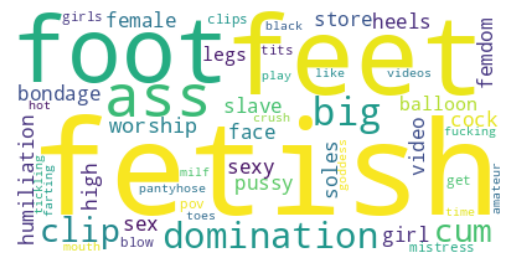

In [23]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [24]:
train_size = int(data.shape[0] * .8)

train = data[:train_size]
val = data[train_size:]

# Split train and test

X_train = train.text_preprocessed.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text_preprocessed.to_numpy()
y_val = val.labels.to_numpy()

In [25]:
train.text_preprocessed.to_numpy()

array(['favorite slut', 'girlfriends sit faces asses',
       'bound beauty kisses girlfriend', ...,
       'gay stud muscle body cock dick fucking jerking jacking masturbating ripped jock worship str8 gay bisexual college guys boys gym workout cumming cum sucking suck nipples hairy pecs twink ass rimming',
       'handjos blackmail step-monther face riding tease denial baby talk bi cuckold chastity milfs brats home wrecker asian face sitting cocktease women control women top decadent women femdom fetish decadent women fucking',
       'empress maxena mistress maxena madame diva herrin lady model fetish fetish-model bizarre bdsm domina mistress prodom dominatrix topdomina goddess nylon foot fetish latex leather rubber uniform bondage slave-training caning spanking cbt whipping lifestyle humiliation strap fetish spanking ass worship bastinado bootfetis hdomina-world pie golden shower'],
      dtype=object)

In [26]:
X_train,  y_train

(array(['favorite slut', 'girlfriends sit faces asses',
        'bound beauty kisses girlfriend', ...,
        'gay stud muscle body cock dick fucking jerking jacking masturbating ripped jock worship str8 gay bisexual college guys boys gym workout cumming cum sucking suck nipples hairy pecs twink ass rimming',
        'handjos blackmail step-monther face riding tease denial baby talk bi cuckold chastity milfs brats home wrecker asian face sitting cocktease women control women top decadent women femdom fetish decadent women fucking',
        'empress maxena mistress maxena madame diva herrin lady model fetish fetish-model bizarre bdsm domina mistress prodom dominatrix topdomina goddess nylon foot fetish latex leather rubber uniform bondage slave-training caning spanking cbt whipping lifestyle humiliation strap fetish spanking ass worship bastinado bootfetis hdomina-world pie golden shower'],
       dtype=object),
 array([0, 0, 0, ..., 0, 0, 0]))

In [27]:
X_train.shape, X_val.shape

((61996,), (15500,))

# Tokenize

In [28]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer2 = Tokenizer(num_words=num_unique_words)
tokenizer2.fit_on_texts(X_train)

In [29]:
import pickle

# saving
with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [30]:
# each word have a unique index
word_index = tokenizer.word_index
word_index

{'fetish': 1,
 'feet': 2,
 'foot': 3,
 'ass': 4,
 'big': 5,
 'domination': 6,
 'cum': 7,
 'worship': 8,
 'clip': 9,
 'bondage': 10,
 'face': 11,
 'cock': 12,
 'slave': 13,
 'sexy': 14,
 'girl': 15,
 'female': 16,
 'femdom': 17,
 'pussy': 18,
 'heels': 19,
 'soles': 20,
 'humiliation': 21,
 'store': 22,
 'high': 23,
 'video': 24,
 'sex': 25,
 'pantyhose': 26,
 'balloon': 27,
 'legs': 28,
 'pov': 29,
 'blow': 30,
 'mistress': 31,
 'tits': 32,
 'get': 33,
 'milf': 34,
 'goddess': 35,
 'mouth': 36,
 'girls': 37,
 'play': 38,
 'hot': 39,
 'fucking': 40,
 'time': 41,
 'tickling': 42,
 'like': 43,
 'farting': 44,
 'black': 45,
 'crush': 46,
 'stockings': 47,
 'fuck': 48,
 'toes': 49,
 'clips': 50,
 'long': 51,
 'hd': 52,
 'socks': 53,
 'amateur': 54,
 'tease': 55,
 'hard': 56,
 'smoking': 57,
 'one': 58,
 'dirty': 59,
 'masturbation': 60,
 'full': 61,
 'training': 62,
 'videos': 63,
 'spanking': 64,
 'little': 65,
 'see': 66,
 'crushing': 67,
 'wrestling': 68,
 'part': 69,
 'woman': 70,
 'wan

In [31]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [32]:
print(X_train[1])
print(X_train_sequences[1])

girlfriends sit faces asses
[1714, 387, 1127, 939]


In [33]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 20

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

X_train_padded.shape, X_val_padded.shape


((61996, 20), (15500, 20))

In [34]:
X_train_padded[10]

array([1143, 3123,  172,   14, 1836,  393,  116,    8,    6,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [35]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

morgan anytime lick sexy mules clean shoe worship domination
[1143, 3123, 172, 14, 1836, 393, 116, 8, 6]
[1143 3123  172   14 1836  393  116    8    6    0    0    0    0    0
    0    0    0    0    0    0]


In [36]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [37]:
reverse_word_index

{1: 'fetish',
 2: 'feet',
 3: 'foot',
 4: 'ass',
 5: 'big',
 6: 'domination',
 7: 'cum',
 8: 'worship',
 9: 'clip',
 10: 'bondage',
 11: 'face',
 12: 'cock',
 13: 'slave',
 14: 'sexy',
 15: 'girl',
 16: 'female',
 17: 'femdom',
 18: 'pussy',
 19: 'heels',
 20: 'soles',
 21: 'humiliation',
 22: 'store',
 23: 'high',
 24: 'video',
 25: 'sex',
 26: 'pantyhose',
 27: 'balloon',
 28: 'legs',
 29: 'pov',
 30: 'blow',
 31: 'mistress',
 32: 'tits',
 33: 'get',
 34: 'milf',
 35: 'goddess',
 36: 'mouth',
 37: 'girls',
 38: 'play',
 39: 'hot',
 40: 'fucking',
 41: 'time',
 42: 'tickling',
 43: 'like',
 44: 'farting',
 45: 'black',
 46: 'crush',
 47: 'stockings',
 48: 'fuck',
 49: 'toes',
 50: 'clips',
 51: 'long',
 52: 'hd',
 53: 'socks',
 54: 'amateur',
 55: 'tease',
 56: 'hard',
 57: 'smoking',
 58: 'one',
 59: 'dirty',
 60: 'masturbation',
 61: 'full',
 62: 'training',
 63: 'videos',
 64: 'spanking',
 65: 'little',
 66: 'see',
 67: 'crushing',
 68: 'wrestling',
 69: 'part',
 70: 'woman',
 71: 

In [38]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(X_train_sequences[10])

print(X_train_sequences[10])
print(decoded_text)

[1143, 3123, 172, 14, 1836, 393, 116, 8, 6]
morgan anytime lick sexy mules clean shoe worship domination


In [39]:
# Create LSTM model
from tensorflow.keras import layers

# Word embeddings give us a way to use an efficient, dense representation in which similar words have
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify)

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

# The layer will take as input as integer matrix of size (batcg, input_length)
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.

model.add(layers.LSTM(64, dropout=.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

2023-03-28 10:50:13.199657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            2195776   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,220,673
Trainable params: 2,220,673
Non-trainable params: 0
_________________________________________________________________


In [40]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate=.001)
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [41]:
model.fit(X_train_padded, y_train, epochs=15, validation_data=(X_val_padded, y_val), verbose=2)

Epoch 1/15
1938/1938 - 43s - loss: 0.0756 - accuracy: 0.9811 - val_loss: 0.1261 - val_accuracy: 0.9663 - 43s/epoch - 22ms/step
Epoch 2/15
1938/1938 - 47s - loss: 0.0294 - accuracy: 0.9905 - val_loss: 0.1511 - val_accuracy: 0.9666 - 47s/epoch - 24ms/step
Epoch 3/15
1938/1938 - 48s - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.1835 - val_accuracy: 0.9666 - 48s/epoch - 25ms/step
Epoch 4/15
1938/1938 - 44s - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.2047 - val_accuracy: 0.9656 - 44s/epoch - 23ms/step
Epoch 5/15
1938/1938 - 47s - loss: 0.0073 - accuracy: 0.9974 - val_loss: 0.2358 - val_accuracy: 0.9669 - 47s/epoch - 24ms/step
Epoch 6/15
1938/1938 - 45s - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.2487 - val_accuracy: 0.9674 - 45s/epoch - 23ms/step
Epoch 7/15
1938/1938 - 49s - loss: 0.0051 - accuracy: 0.9984 - val_loss: 0.2763 - val_accuracy: 0.9668 - 49s/epoch - 25ms/step
Epoch 8/15
1938/1938 - 48s - loss: 0.0037 - accuracy: 0.9986 - val_loss: 0.2775 - val_accuracy: 0.9670 - 48s/ep

In [42]:
# model.get_weights()

In [46]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

,loss,accuracy,val_loss,val_accuracy
0,0.075574,0.981112,0.126143,0.966323
1,0.029353,0.990548,0.151067,0.966645
2,0.016514,0.994725,0.183541,0.966581
3,0.010320,0.996468,0.204668,0.965613
4,0.007341,0.997371,0.235842,0.966903
5,0.005576,0.998258,0.248702,0.967419
6,0.005077,0.998371,0.276276,0.966774
7,0.003740,0.998629,0.277489,0.966968
8,0.003341,0.998710,0.286126,0.967936
9,0.002774,0.999129,0.274634,0.966452


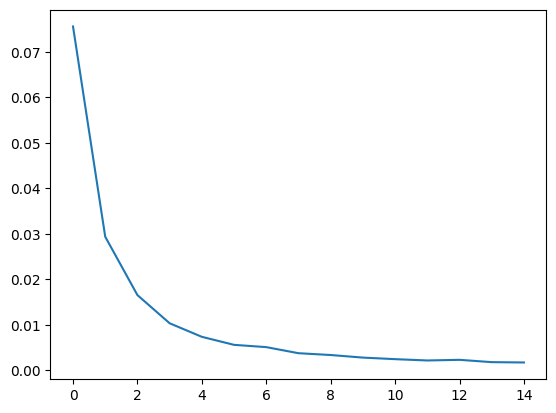

In [44]:
import matplotlib.pyplot as plt
plt.plot(history_df.loss);

In [47]:
predictions = model.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1938/1938 [==============================] - 8s 3ms/step


In [48]:
print(X_train[60:70])
print(y_train[60:70])
print(predictions[60:70])

['2212kendra-make look like fucked bound gagged'
 'rude roommates stinky feet pov part 2 princess yasmine hd1080p'
 'work socks' 'foot massage big feet hd'
 'pov crushing experience adidas cool climate sneakers 4k'
 'diana knight pin pop balloon contest'
 'diana knight balloon pin pop contest'
 'diana knight balloons pin pop contest' '19jule2021_shorthj'
 'diana knight balloons pin pop games']
[0 0 0 0 0 0 0 0 0 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [49]:
train['predictions'] = predictions
train = train[['text_preprocessed', 'labels', 'predictions', 'text']] # columns reorder

In [50]:
train.head()

,text_preprocessed,labels,predictions,text
0,favorite slut,0,0,My Favorite Slut
1,girlfriends sit faces asses,0,0,girlfriends sit on each other's faces with the...
2,bound beauty kisses girlfriend,0,0,bound beauty kisses her girlfriend
3,morgan anytime nail painting slave face,0,0,MORGAN - Anytime - Nail Painting On The Slave'...
4,transgender coaching wmv part 1,0,0,TRANSGENDER COACHING (wmv) PART 1


In [51]:
train.to_csv('../datasets/wo_html.csv')

In [52]:
model.save('../models/modelSequential_wo_HTML.h5')

In [53]:
#model_new = keras.models.load_model('../models/modelSequential.h5')
model_new = keras.models.load_model('../models/modelSequential_wo_HTML.h5')

In [54]:
predictions = model_new.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1938/1938 [==============================] - 7s 3ms/step


# Check sentence

In [55]:
raw_text = ""
test_text_preprocessed = bs(raw_text).get_text().replace('\n',' ')
test_text_preprocessed = preprocess(test_text_preprocessed, punctuation_marks, stop_words)
test_text_np = np.array([test_text_preprocessed])
test_sequences = tokenizer.texts_to_sequences(test_text_np)

In [56]:
print(test_text_preprocessed)
print(test_sequences[0])

cadence lux tina lee comet nate liquor tina hard time finding hot ladies tie fuck hires older luck guy nate catfish kinky needs tindr lure hottie tie tina luck first try cadence lezbo slut loves tied additional formatshdmobile 'll also love wife husband coffee shop pussy falling trap
[2670, 2852, 2974, 2205, 10043, 2974, 56, 41, 3420, 39, 441, 783, 48, 8926, 471, 4944, 425, 10043, 518, 635, 10468, 2207, 783, 2974, 4944, 101, 375, 2670, 29978, 121, 345, 98, 7369, 245, 158, 89, 169, 634, 2079, 3343, 18, 4665, 3647]


In [57]:
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

In [58]:
%%time
predictions = model_new.predict(test_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1/1 [==============================] - 0s 21ms/step
CPU times: user 70.8 ms, sys: 4.99 ms, total: 75.8 ms
Wall time: 125 ms


In [59]:
predictions

[0]

In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 20

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# max words in a sequence
max_length = 20

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', "'", '(', ')', ':', '-', '--', '', '?', '@', '....', '~',
                     '.', '..', '...', '<', '>', '=', '==', '\'\'', '//', '»', '|', '’', '`', '+',
                     '\"\"', '</', '&', '/', '#', '\'', '*', '``', '%', '[', ']', '{', '}', '$']


stop_words = stopwords.words('english') + ['14000kbps', 'https', "'s", "'m", 'http', 'mp4', 'error', '404']

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
model = keras.models.load_model('../models/modelSequential.h5')

raw_text = '<p>Socks. Such a simple, common and necessary item. I love wearing socks. Frilly socks, fuzzy socks, reinforced toe and heel socks, sweat socks, lace socks, statement socks! I love finding cute colors to match and contrast my shoes and clothes. I actually sold many pairs of socks during college to cover my club visits. Lucky boys. Also, for animals that do not know how to shut their mouths. \"Put a sock in it\" literally does work. It is kind of weird how much I enjoy hearing the slurping and sucking sounds coming from the floor beneath me. \"Yes, I want that sock sucked cleaned foot mutt. Keep that mouth busy for me like a good boy.\"</p>'


def predict(sequences):
    sequences_padded = pad_sequences(sequences, maxlen=20, padding="post", truncating="post")
    predictions = model.predict(sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]
    return predictions

# Data loading and preparation
data = pd.read_json('../datasets/neil_ProducerClipSite_rand.json')
mapping = {False: 0, True: 1}
# data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
# data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['SiteID', 'Title', 'Description', 'Keywords', 'Bottom'], axis=1, inplace=True)
data.head()



In [ ]:
data.Top

In [ ]:
%%time
data['text_preprocessed'] = data.apply(lambda row: bs(row.Top, 'lxml').get_text().replace('\n',' '), axis=1)
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text_preprocessed, punctuation_marks, stop_words), axis=1)

X_val = data.text_preprocessed.to_numpy()
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

predictions = model.predict(X_val_padded)
predictions = [1 if p > .5 else 0 for p in predictions]


In [ ]:
data['predictions'] = predictions

In [ ]:
data.head()

In [ ]:
data = data[['Top', 'predictions']]

In [ ]:
data.to_csv('../datasets/last_one.csv')

In [ ]:
data.to_json('../datasets/last_one.json')